In [11]:
%matplotlib widget

# The potential of the electromagnetic induction method to monitor temperature changes in the near-surface

## Maria Carrizo, Dieter Werthmüller, and Evert Slob
Delft University of Technology, Faculty of Civil Engineering and Geosciences , Department of Applied Geophysics and Petrophysics, Delft, Netherlands (m.e.carrizomascarell@tudelft.nl)

In [39]:
# Import Libraries

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from empymod import filters
import sys
sys.path.insert(1, 'src')

# Load function that performs global search in lookup table
from EM1D import EMf_2Lay_HVP, EMf_3Lay_HVP, GlobalSearch_2Lay, GlobalSearch_3Lay

In [6]:
# Settings for measurements simulations

# Define hankel filter
filt = filters.key_201_2012() 

# Define EMI instrument geometry
offsets = np.array([2, 4, 8]) # in meters
height = 0.10 # meters height from ground surface to center of coils
freq = 9000 # Frequency in Hz
# Lambda numbers
lambd = filt.base/offsets[:,np.newaxis] 

## Calculate the increase of EC in groundwater with temperature

From [Hermans et. al., 2012](https://doi.org/10.1190/geo2011-0199.1) we simulate a shallow acquifer with the following characteristics

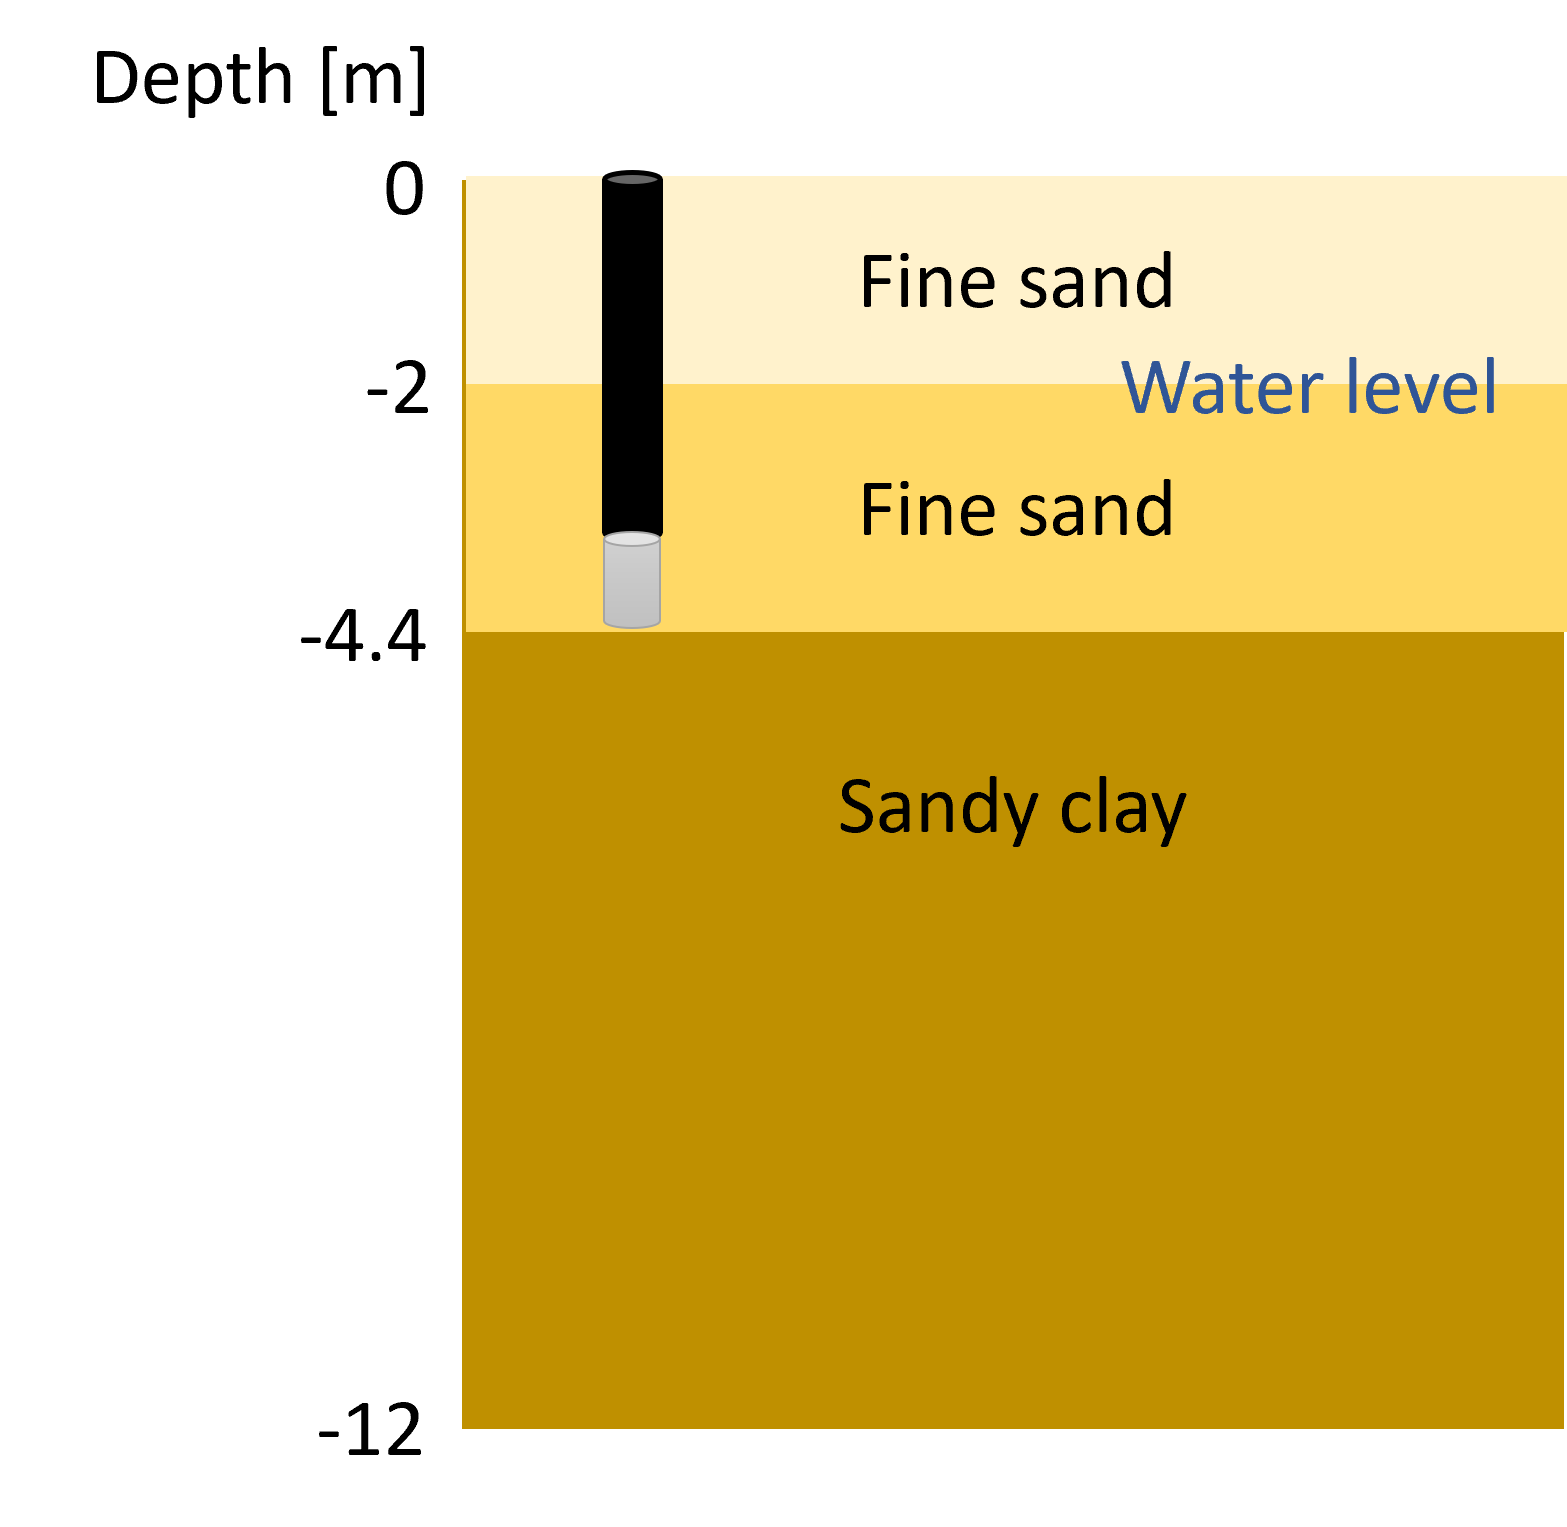

In [13]:
Image(filename = "Lithology.png", width=300, height=300)

The first 4.4 meters of the field site consist of fine sands. These sands cover a sandy clay layer which is less permeable. The water level lies at −2 m. The injection well is drilled in the fine sands and is screened between −3.5 and −4.4 m.

The electrical conductivities of the model are:
- Fine sand unsaturated: 10 mS/m
- Fine sand saturated: 30 mS/m
- Sandy clay: 350 mS/m

### Petrophysical relationships

A linear dependence between electric conductivity and temperature of soil/rock can be assumed when limited temperature intervals are considered (a few tens of degrees). The following equation expresses the linear relation around 25°C [Hayley et al., 2007](https://doi.org/10.1190/1.3478208)

\begin{equation}
\frac{\sigma_T}{\sigma_{25}} = m(T - 25) + 1, 
\end{equation}

where $\sigma_T$ is the electric conductivity of soil/rock at temperature $T$ (in $°C$), m is the fractional change in electric conductivity per degree Celsius. The value of $m$ can be experimentally determined and varies according to the type of fluid and sediments. A value of 0.020 $°C^{−1}$ is used for $m$ in this experiments

### The effect of temperature in the bulk electrical conductivity

In saturated sediments, the previous equation indicates that the bulk electric conductivity is directly proportional to the fluid electric conductivity, neglecting the surface conductivity. 

Assuming:
- A change from 10 $°C$ (baseline) to 50 $°C$ in the groundwater. 
- $\sigma_{25}$ = 35 mS/m for the saturated fine sand
- $m$ = 0.020 $°C^{-1}$

We would have for the case of the saturated fine sand, following the previous equation:

Text(10, 60, 'The fractional change per degree Celcius is 1.7%')

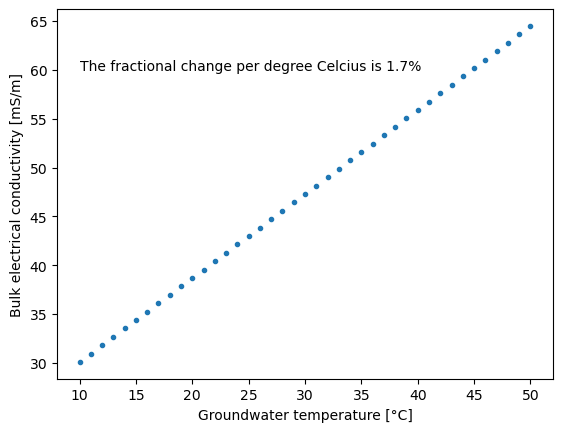

In [119]:
ini_temp = 10
end_temp = 51

T = np.linspace(ini_temp, end_temp, 41, endpoint=False)
sigma_25 = 43
m = 0.020

sigma_bulk = (m * (T - 25) + 1) * sigma_25

sigma_ini = sigma_bulk[0]
sigma_end = sigma_bulk[-1]

Frac_change = (sigma_end - sigma_ini)/(end_temp - ini_temp)/50*100

fig, ax = plt.subplots()
ax.plot(T, sigma_bulk, '.')
ax.set_xlabel('Groundwater temperature [°C]')
ax.set_ylabel('Bulk electrical conductivity [mS/m]')
ax.text(10, 60,'The fractional change per degree Celcius is ' + "{:1.1f}".format(Frac_change) + '%')

## EM Induction 

For the models data is simulated for an EMI device with the following characteristics
  - Frequency: 9000 Hz
  - Geometries: Horizontal coplanar (H) with offsets [2 m, 4 m, 8 m], Vertical coplanar (V) with offsets [2 m, 4 m, 8 m], and Perpendicular (P) with offsets [2.1 m, 4.1 m, 8.1 m]
  - Data obtained: vector with the Quadrature (Q) and In-phase (IP) components of the measurements for the H, V and P coil orientations as [Q_H2, Q_H4, Q_H8, Q_V2, Q_V4, Q_V8, Q_P2, Q_P4, Q_P8, IP_H2, IP_H4, IP_H8, IP_V2, IP_V4, IP_V8, IP_P2, IP_P4, IP_P8]



### Simulate data difference

For a range of time steps we simulate synthetic data and analyse the data difference  

- Time Step 1: $T = 10 °C$ (Baseline)
- Time Step 2: $T = 20 °C$
- Time Step 3: $T = 30 °C$
- Time Step 4: $T = 40 °C$
- Time Step 5: $T = 50 °C$

In [ ]:
def PlotModelData(model, depths, data, ax=None, model_name='', model_style='k', data_style='.'):
    if ax is None:
        fig, ax = plt.subplots(1,2)
    ax[0].step(model, depths, model_style)
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Electrical conductivity [mS/m]')
    ax[0].set_ylabel('Depth [m]')
    ax[0].set_title(model_name)

    ax[1].plot(data[:9]*1000, data_style+'g', label='Q [ppt]')
    ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax[1].set_xticklabels(['H2', 'H4', 'H8', 'V2', 'V4', 'V8', 'P2', 'P4', 'P8'])
    ax[1].plot(data[9:]*1000, data_style+'r', label = 'IP [ppt]')
    ax[1].set_xlabel('Coil geometry')
    ax[1].legend()
    ax[1].set_title('EMI measurements')

    plt.tight_layout()

In [122]:
# Experiment parameters:

sigma_fs1 = 10 # mS/m sigma fine sand unsaturated
sigma_sc  = 350 # mS/m sigma of sandy clay
h1 = 2 # Thickness of first layer
h2 = 2.4 # Thickness of second layer
dmax = 12

# Time steps

# Defining sigma_fs2 for each time step
sigma_fs2_TS1 = sigma_bulk[np.argwhere(T == 10)[0][0]]


# Define EC models
model_TS1 = np.array([sigma_fs1, , sigma_sc, sigma_sc])
model_TS2 = np.array([sigma_fs2, sigma_bulk[np.argwhere(T == 20)[0][0]], sigma_sc, sigma_sc])
model_TS3 = np.array([sigma_fs2, sigma_bulk[np.argwhere(T == 30)[0][0]], sigma_sc, sigma_sc]) 
model_TS4 = np.array([sigma_fs2, sigma_bulk[np.argwhere(T == 40)[0][0]], sigma_sc, sigma_sc]) 
model_TS5 = np.array([sigma_fs2, sigma_bulk[np.argwhere(T == 50)[0][0]], sigma_sc, sigma_sc]) 

depths = np.array([0, -h1, -h1 - h2, -dmax])

# Simulate measurements
# Note: Sigmas in unit of S/m

data_TS1 = EMf_3Lay_HVP(lambd = lambd, sigma1 = sigma_fs1/1000,
                         sigma2 = sigma_fs2/1000,
                         sigma3 = sigma_sc/1000,
                         h1 = h1,
                         h2 = h2,
                         height = height,
                         offsets = offsets,
                         freq = freq,
                         filt = filt)

### 2-layered case

Using the baseline model and inverting a 2-layered model we simulate the measurements

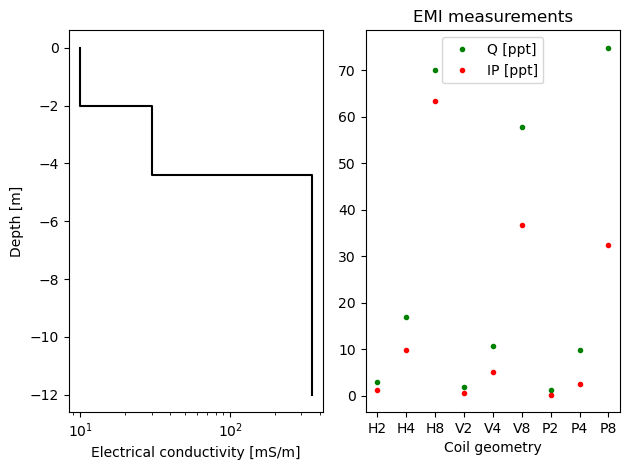

In [91]:
sigma_fs1 = 10 # mS/m
sigma_fs2 = 30 # mS/m
sigma_sc  = 350 # mS/m
h1 = 2 # Thickness of first layer
h2 = 2.4 # Thickness of second layer

depths = np.array([0, -2, -4.4, -12])
model_base = np.array([sigma_fs1, sigma_fs2, sigma_sc, sigma_sc])

# Simulate measurements for the baseline case
data_base = EMf_3Lay_HVP(lambd = lambd, 
                         sigma1 = sigma_fs1/1000,
                         sigma2 = sigma_fs2/1000,
                         sigma3 = sigma_sc/1000,
                         h1 = h1,
                         h2 = h2,
                         height = height,
                         offsets = offsets,
                         freq = freq,
                         filt = filt)

def PlotModelData(model, depths, data, ax=None, model_name='', model_style='k', data_style='.'):
    if ax is None:
        fig, ax = plt.subplots(1,2)
    ax[0].step(model, depths, model_style)
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Electrical conductivity [mS/m]')
    ax[0].set_ylabel('Depth [m]')
    ax[0].set_title(model_name)

    ax[1].plot(data[:9]*1000, data_style+'g', label='Q [ppt]')
    ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax[1].set_xticklabels(['H2', 'H4', 'H8', 'V2', 'V4', 'V8', 'P2', 'P4', 'P8'])
    ax[1].plot(data[9:]*1000, data_style+'r', label = 'IP [ppt]')
    ax[1].set_xlabel('Coil geometry')
    ax[1].legend()
    ax[1].set_title('EMI measurements')

    plt.tight_layout()
    
PlotModelData(model_base, depths, data_base)

### Lookup table search

Assuming a 2-layered model we perform a global search in a Lookup table and obtain the following result:

In [56]:
# Load lookup table and sampling ranges used
LU_2Lay = np.load('Lookup_Tables/2Lay/LUTable_2Lay.npy')
conds = np.load('Lookup_Tables/2Lay/conds.npy')
thicks = np.load('Lookup_Tables/2Lay/thicks.npy')
# number of samples
nsl = len(conds)

model_est_2Lay = GlobalSearch_2Lay(LU_2Lay, data_base, conds, thicks, nsl)

In [58]:
data_est_2Lay = EMf_2Lay_HVP(lambd = lambd,
                             sigma1 = model_est_2Lay[0],
                             sigma2 = model_est_2Lay[1],
                             h1 = model_est_2Lay[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

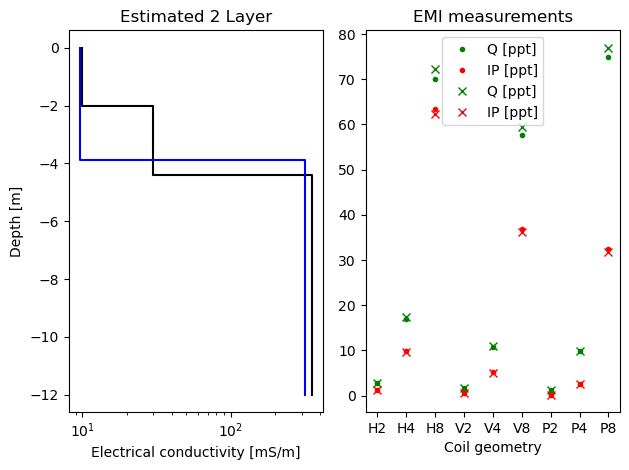

In [92]:
model_est_2Lay_plot = np.hstack((model_est_2Lay[:2]*1000, model_est_2Lay[1]*1000))
depths_est_2Lat_plot = np.array(([0, -model_est_2Lay[-1], -12]))

fig, ax = plt.subplots(1,2)
PlotModelData(model_base, depths, data_base, ax=ax)
PlotModelData(model_est_2Lay_plot, depths_est_2Lat_plot, data_est_2Lay, ax=ax, model_name='Estimated 2 Layer',
             model_style='b', data_style='x')